# Airbnb Data Analysis

This analysis aims to discover the characteristics of the properties listed on Airbnb accross New York City. Data was collected from the Inside Airbnb project at https://insideairbnb.com/get-the-data/. Data description is available at https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing. The last day of scraping for this dataset was July 5th, 2024.

## Setup

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import re

from mpl_toolkits.axes_grid1 import make_axes_locatable

pd.options.display.max_columns = None

## Importing Data

In [156]:
geo_data = gpd.read_file('./data/neighbourhoods.geojson')

<Axes: >

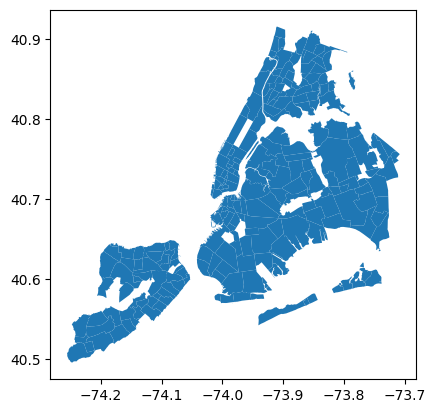

In [157]:
geo_data["geometry"].plot()

In [158]:
listings = pd.read_csv("./data/listings.csv")
listings.head()

id                        listing_url       scrape_id last_scraped  \
0  2595  https://www.airbnb.com/rooms/2595  20240705150938   2024-07-06   
1  5136  https://www.airbnb.com/rooms/5136  20240705150938   2024-07-05   
2  6848  https://www.airbnb.com/rooms/6848  20240705150938   2024-07-06   
3  6872  https://www.airbnb.com/rooms/6872  20240705150938   2024-07-05   
4  6990  https://www.airbnb.com/rooms/6990  20240705150938   2024-07-06   

        source                                               name  \
0  city scrape                              Skylit Midtown Castle   
1  city scrape    Spacious Family Friendly Duplex w/ Patio + Yard   
2  city scrape                   Only 2 stops to Manhattan studio   
3  city scrape  Uptown Sanctuary w/ Private Bath (Month to Month)   
4  city scrape                            UES Beautiful Blue Room   

                                         description  \
0  Beautiful, spacious skylit studio in the heart...   
1  We welcome you to stay in our lovely 2 br, 130...   
2  Comfortable studio apartment with super comfor...   
3  A charming month-to-month home away from home ...   
4                    Beautiful peaceful healthy home   

                               neighborhood_overview  \
0  Centrally located in the heart of Manhattan ju...   
1                                                NaN   
2                                                NaN   
3  This sweet Harlem sanctuary is a 10-20 minute ...   
4  Location: Five minutes to Central Park, Museum...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/miso/Hosting-...     2845   
1  https://a0.muscache.com/pictures/miso/Hosting-...     7378   
2  https://a0.muscache.com/pictures/e4f031a7-f146...    15991   
3  https://a0.muscache.com/pictures/miso/Hosting-...    16104   
4  https://a0.muscache.com/pictures/be6cd5b3-9295...    16800   

                                  host_url      host_name  host_since  \
0   https://www.airbnb.com/users/show/2845       Jennifer  2008-09-09   
1   https://www.airbnb.com/users/show/7378        Rebecca  2009-02-03   
2  https://www.airbnb.com/users/show/15991  Allen & Irina  2009-05-06   
3  https://www.airbnb.com/users/show/16104            Kae  2009-05-07   
4  https://www.airbnb.com/users/show/16800            Cyn  2009-05-12   

   host_location                                         host_about  \
0  Woodstock, NY  A New Yorker since 2000! My passion is creatin...   
1   New York, NY  Rebecca is an artist/designer, and Henoch is i...   
2   New York, NY  We love to travel. When we travel we like to s...   
3   New York, NY  A former life in fashion and wellness has left...   
4   New York, NY  Capturing the Steinbeck side of life in its Fi...   

   host_response_time host_response_rate host_acceptance_rate  \
0  a few days or more                43%                  21%   
1      within an hour               100%                 100%   
2      within an hour               100%                 100%   
3        within a day                50%                   0%   
4      within an hour               100%                 100%   

  host_is_superhost                                 host_thumbnail_url  \
0                 f  https://a0.muscache.com/im/pictures/user/50fc5...   
1                 f  https://a0.muscache.com/im/users/7378/profile_...   
2                 t  https://a0.muscache.com/im/users/15991/profile...   
3                 f  https://a0.muscache.com/im/pictures/user/d865a...   
4                 t  https://a0.muscache.com/im/pictures/user/17c4d...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/user/50fc5...            Midtown   
1  https://a0.muscache.com/im/users/7378/profile_...  Greenwood Heights   
2  https://a0.muscache.com/im/users/15991/profile...       Williamsburg   
3  https://a0.muscache.com/im/pictures/user/d865a...        East Harlem 

In [159]:
listings.columns.tolist()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30

I will filter the dataset by columns I believe will be relevant for analysis based on decription posted on [Data Dictionary](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing). I didn't include information like host URL, picture URL, neighborhood overview, such information that won't add value to the analysis.

In [160]:
wanted_cols = [
    'host_id',
    'name',
    'host_location',
    'host_response_time',
    'host_response_rate',
    'host_acceptance_rate',
    'host_is_superhost',
    'host_name',
    'host_neighbourhood',
    'host_listings_count',
    'host_total_listings_count',
    'host_verifications',
    'host_has_profile_pic',
    'host_identity_verified',
    'neighbourhood_cleansed',
    'neighbourhood_group_cleansed',
    'latitude',
    'longitude',
    'property_type',
    'room_type',
    'accommodates',
    'bathrooms',
    'bathrooms_text',
    'bedrooms',
    'beds',
    'amenities',
    'price',
    'minimum_nights',
    'maximum_nights',
    'has_availability',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365',
    'number_of_reviews',
    'number_of_reviews_ltm',
    'number_of_reviews_l30d',
    'first_review',
    'last_review',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'instant_bookable',
    'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms',
    'reviews_per_month'
]

In [161]:
listings = listings.filter(items=wanted_cols, axis=1)

In [162]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37765 entries, 0 to 37764
Data columns (total 52 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_id                                       37765 non-null  int64  
 1   name                                          37763 non-null  object 
 2   host_location                                 29703 non-null  object 
 3   host_response_time                            23035 non-null  object 
 4   host_response_rate                            23035 non-null  object 
 5   host_acceptance_rate                          24845 non-null  object 
 6   host_is_superhost                             37367 non-null  object 
 7   host_name                                     37760 non-null  object 
 8   host_neighbourhood                            30258 non-null  object 
 9   host_listings_count                           37760 non-null 

The dataset has 37765 entries with 53 columns after removal. Originally, 15 entries are float64, 15 are int64 and 23 are objects. A lot of columns have missing data and I will deal with that later.

## Data Cleaning

In [163]:
listings.head(3)

host_id                                             name  host_location  \
0     2845                            Skylit Midtown Castle  Woodstock, NY   
1     7378  Spacious Family Friendly Duplex w/ Patio + Yard   New York, NY   
2    15991                 Only 2 stops to Manhattan studio   New York, NY   

   host_response_time host_response_rate host_acceptance_rate  \
0  a few days or more                43%                  21%   
1      within an hour               100%                 100%   
2      within an hour               100%                 100%   

  host_is_superhost      host_name host_neighbourhood  host_listings_count  \
0                 f       Jennifer            Midtown                  7.0   
1                 f        Rebecca  Greenwood Heights                  1.0   
2                 t  Allen & Irina       Williamsburg                  1.0   

   host_total_listings_count                host_verifications  \
0                        9.0  ['email', 'phone', 'work_email']   
1                        5.0                ['email', 'phone']   
2                        1.0                ['email', 'phone']   

  host_has_profile_pic host_identity_verified neighbourhood_cleansed  \
0                    t                      t                Midtown   
1                    t                      t            Sunset Park   
2                    t                      t           Williamsburg   

  neighbourhood_group_cleansed  latitude  longitude       property_type  \
0                    Manhattan  40.75356  -73.98559  Entire rental unit   
1                     Brooklyn  40.66265  -73.99454  Entire rental unit   
2                     Brooklyn  40.70935  -73.95342  Entire rental unit   

         room_type  accommodates  bathrooms bathrooms_text  bedrooms  beds  \
0  Entire home/apt             1        1.0         1 bath       0.0   1.0   
1  Entire home/apt             4        1.5      1.5 baths       2.0   2.0   
2  Entire home/apt             3        1.0         1 bath       2.0   1.0   

                                           amenities    price  minimum_nights  \
0  ["Smoke alarm", "Heating", "Bed linens", "Oven...      NaN              30   
1  ["Smoke alarm", "Heating", "Dryer", "Bed linen...  $215.00              30   
2  ["Smoke alarm", "Heating", "Bed linens", "Oven...   $81.00              30   

   maximum_nights has_availability  availability_30  availability_60  \
0            1125                t               13               30   
1             730                t                2               11   
2             730                t                0                5   

   availability_90  availability_365  number_of_reviews  \
0               60               300                 49   
1               11                71                  4   
2                5               193                193   

   number_of_reviews_ltm  number_of_reviews_l30d first_review last_review  \
0                      0                       0   2009-11-21  2022-06-21   
1                      1                       0   2014-01-02  2023-08-20   
2                      3                       0   2009-05-25  2024-05-18   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  4.68                    4.73                       4.63   
1                  4.75                    4.75                       4.50   
2                  4.58                    4.59                       4.86   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                   4.77                          4.8                    4.81   
1                   5.00                          5.0                    4.75   
2                   4.85                          4.8                    4.68   

   review_scores_value instant_bookable  calculated_host_listings_count  \
0                 4.40                f                               3   


In [164]:
listings["host_response_rate"] = listings["host_response_rate"].str.replace("%", "").astype(float) / 100
listings["host_acceptance_rate"] = listings["host_acceptance_rate"].str.replace("%", "").astype(float) / 100

## Initial Exploration

### Host with most properties

In [165]:
listings.describe()

host_id  host_response_rate  host_acceptance_rate  \
count  3.776500e+04        23035.000000          24845.000000   
mean   1.659684e+08            0.903126              0.794564   
std    1.800529e+08            0.233661              0.275194   
min    1.678000e+03            0.000000              0.000000   
25%    1.662776e+07            0.960000              0.710000   
50%    8.218953e+07            1.000000              0.920000   
75%    3.031569e+08            1.000000              1.000000   
max    5.869174e+08            1.000000              1.000000   

       host_listings_count  host_total_listings_count      latitude  \
count         37760.000000               37760.000000  37765.000000   
mean            205.595101                 284.513745     40.729075   
std             819.005123                1027.543106      0.056343   
min               1.000000                   1.000000     40.500366   
25%               1.000000                   1.000000     40.688800   
50%               2.000000                   3.000000     40.726440   
75%               9.000000                  13.000000     40.762470   
max            4641.000000                9013.000000     40.911390   

          longitude  accommodates     bathrooms      bedrooms          beds  \
count  37765.000000  37765.000000  23172.000000  31882.000000  22988.000000   
mean     -73.947084      2.761949      1.188525      1.386205      1.636593   
std        0.054458      1.922789      0.548367      0.936081      1.182118   
min      -74.251907      1.000000      0.000000      0.000000      0.000000   
25%      -73.983220      2.000000      1.000000      1.000000      1.000000   
50%      -73.954540      2.000000      1.000000      1.000000      1.000000   
75%      -73.928022      4.000000      1.000000      2.000000      2.000000   
max      -73.713650     16.000000     15.500000     16.000000     42.000000   

       minimum_nights  maximum_nights  availability_30  availability_60  \
count    37765.000000    3.776500e+04     37765.000000     37765.000000   
mean        29.164597    5.797700e+04         9.041785        22.083728   
std         30.202538    1.105105e+07        12.126443        24.229526   
min          1.000000    1.000000e+00         0.000000         0.000000   
25%         30.000000    1.500000e+02         0.000000         0.000000   
50%         30.000000    3.650000e+02         0.000000        11.000000   
75%         30.000000    1.125000e+03        22.000000        49.000000   
max       1250.000000    2.147484e+09        30.000000        60.000000   

       availability_90  availability_365  number_of_reviews  \
count     37765.000000      37765.000000       37765.000000   
mean         36.027062        152.411598          24.898981   
std          36.384337        142.797333          58.802122   
min           0.000000          0.000000           0.000000   
25%           0.000000          0.000000           0.000000   
50%          28.000000        126.000000           3.000000   
75%          74.000000        301.000000          21.000000   
max          90.000000        365.000000        1915.000000   

       number_of_reviews_ltm  number_of_reviews_l30d  review_scores_rating  \
count           37765.000000            37765.000000          26014.000000   
mean                3.993168                0.298186              4.727302   
std                15.762591                1.770795              0.435394   
min                 0.000000                0.000000              0.000000   
25%                 0.000000                0.000000              4.650000   
50%                 0.000000                0.000000              4.850000   
75%                 3.000000                0.000000              5.000000   
max              1568.000000              151.000000              5.000000   

       review_scores_accuracy  review_scores_cleanliness  \
count            25997.000000               26007.000000   
mean   

Visualizing the statistical description we get a sense of scale on things, for instance, the host with most listings has 4641 listings, but the median is 2 listings, which means the distribution is probably skewed to the right and we can check by plotting a histogram for this

In [166]:
# plt.hist(listings["host_listings_count"], bins=100);
px.histogram(listings, x="host_listings_count", nbins=50)

The histogram is not a very good visualization, so we will try a boxplot, which will also not look good due to the exaggerated skewness. The benefit of using plotly express is the possibility to zoom in a specific section of the chart

In [167]:
px.box(listings, x="host_listings_count")

In [168]:
listings_of_max_listing_count = listings[listings["host_listings_count"] == listings["host_listings_count"].max()]
print(listings_of_max_listing_count["host_id"].nunique())
print(listings_of_max_listing_count.shape)

1
(842, 52)


We see even though this host has 4641 listings, not all are on this dataset. We shall inspect the ones that are.

In [169]:
max_listings_host = listings_of_max_listing_count["host_id"]
listings_of_max_listing_count["neighbourhood_cleansed"].nunique()

34

Above we showed that this host has properties in 34 different neighborhoods...

In [170]:
listings_of_max_listing_count["neighbourhood_cleansed"].mode()

0    Midtown
Name: neighbourhood_cleansed, dtype: object

... and the one with most properties is Midtown, in Manhattan.

In [171]:
geo_data['neighbourhood_frequency'] = geo_data['neighbourhood'].apply(lambda x: (listings_of_max_listing_count['neighbourhood_cleansed'] == x).sum())

In [172]:
geo_data.sort_values(by='neighbourhood_frequency', ascending=False).head()

neighbourhood neighbourhood_group  \
148             Midtown           Manhattan   
94   Financial District           Manhattan   
219     Upper West Side           Manhattan   
52              Chelsea           Manhattan   
218     Upper East Side           Manhattan   

                                              geometry  \
148  MULTIPOLYGON (((-73.96223 40.75452, -73.96792 ...   
94   MULTIPOLYGON (((-74.01375 40.71369, -74.00861 ...   
219  MULTIPOLYGON (((-73.95836 40.80037, -73.98144 ...   
52   MULTIPOLYGON (((-73.99346 40.75219, -73.98794 ...   
218  MULTIPOLYGON (((-73.94359 40.78275, -73.94365 ...   

     neighbourhood_frequency  
148                      108  
94                        98  
219                       94  
52                        60  
218                       57

### Visualizing Heatmap of properties for this host

(-74.2829793, -73.6804367) (40.47516405, 40.936502950000005)


/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_5570/1486526000.py:26: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




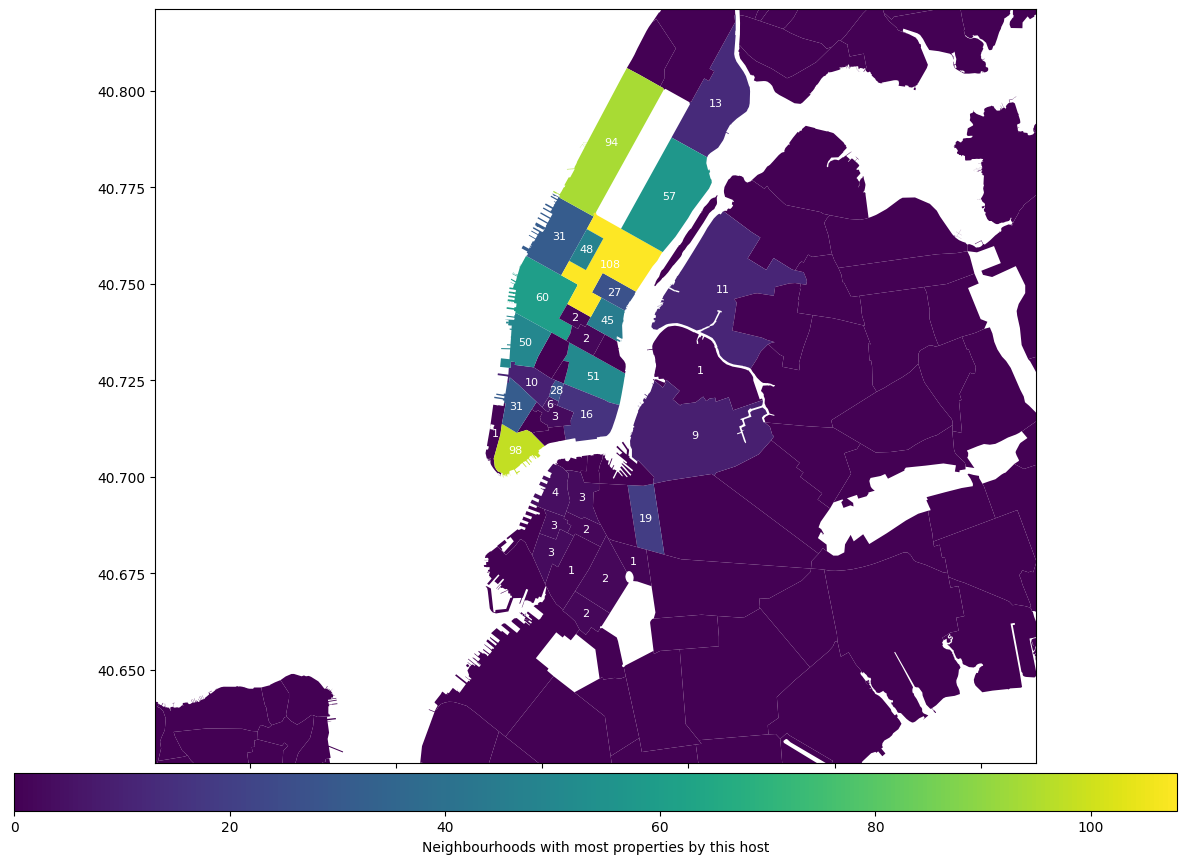

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="5%", pad=0.1)

geo_data.plot(
    ax=ax, 
    cax=cax, 
    legend=True, 
    column='neighbourhood_frequency',
    legend_kwds={"label": "Neighbourhoods with most properties by this host", "orientation": "horizontal"}
)
print(ax.get_xlim(), ax.get_ylim())
x, y = ax.get_xlim(), ax.get_ylim()

x_ref = (x[0] - x[1]) / 4
y_ref = (y[0] - y[1]) / 4

new_x = (x[0] - x_ref, x[1] + x_ref)
new_y = (y[0] - x_ref, y[1] + y_ref)

ax.set_xlim(new_x)
ax.set_ylim(new_y)

for x, y, label in zip(geo_data.geometry.centroid.x, geo_data.geometry.centroid.y, geo_data['neighbourhood_frequency']):
    if label > 0:
        ax.text(x, y, str(label), fontsize=8, ha='center', va='center', color='white')  # Position the text

plt.show()

In [174]:
listings_of_max_listing_count["host_name"]

9580     Blueground
10782    Blueground
11024    Blueground
11164    Blueground
11357    Blueground
            ...    
37610    Blueground
37615    Blueground
37616    Blueground
37617    Blueground
37618    Blueground
Name: host_name, Length: 842, dtype: object

A bit of research shows that Blueground is an apartment rental service in New York City with all kinds of properties and some of them listed on Airbnb. This explains why they have so many listings. More info on https://www.theblueground.com/furnished-apartments-new-york-usa

## Macro Overview of all listings

First, let's see where most listings are located

In [175]:
geo_data['neighbourhood_frequency'] = geo_data['neighbourhood'].apply(lambda x: (listings['neighbourhood_cleansed'] == x).sum())
geo_data['neighbourhood_group_frequency'] = geo_data['neighbourhood_group'].apply(lambda x: (listings['neighbourhood_group_cleansed'] == x).sum())

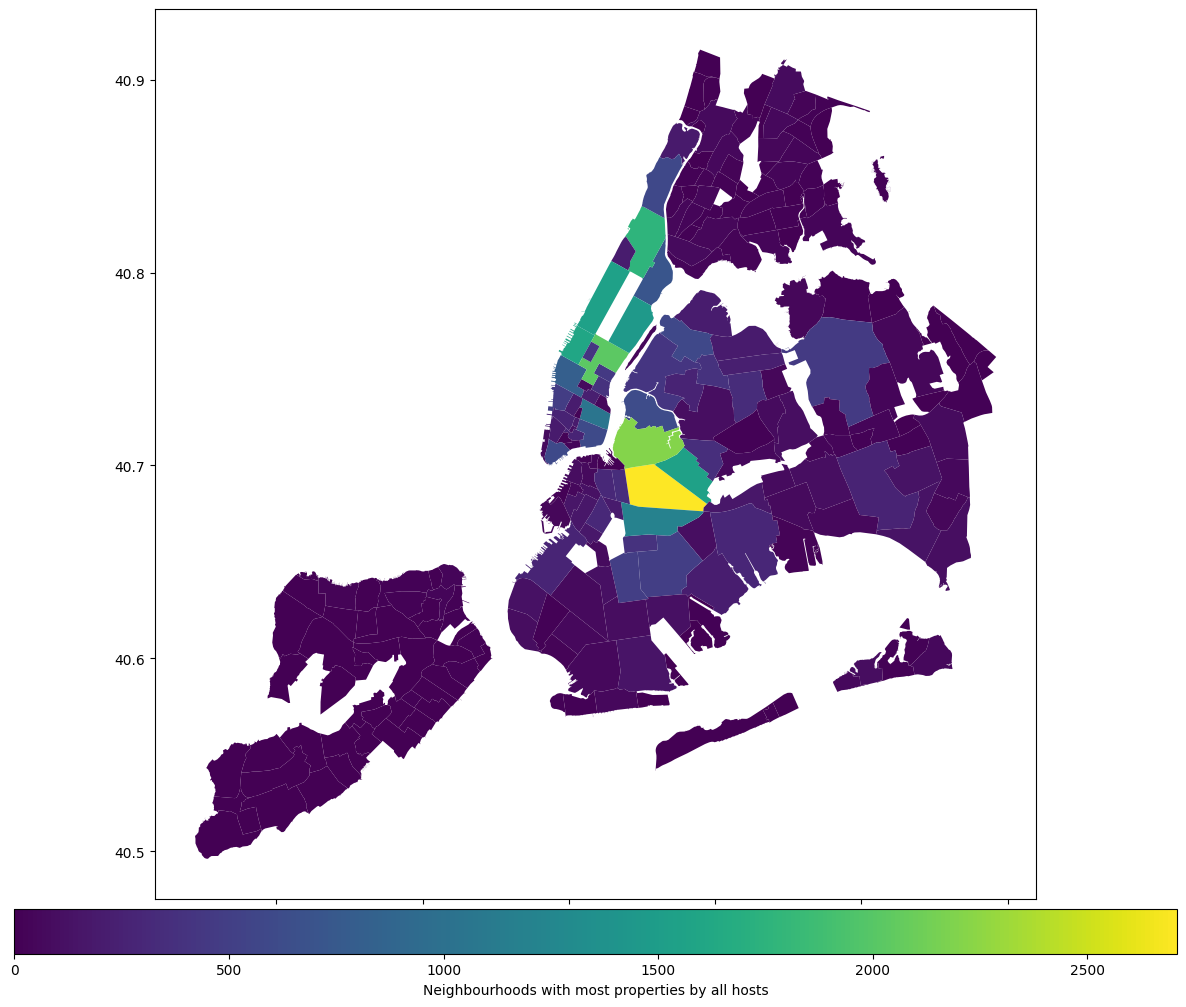

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="5%", pad=0.1)

geo_data.plot(
    ax=ax, 
    cax=cax, 
    legend=True, 
    column='neighbourhood_frequency',
    legend_kwds={"label": "Neighbourhoods with most properties by all hosts", "orientation": "horizontal"}
)

# for x, y, label in zip(geo_data.geometry.centroid.x, geo_data.geometry.centroid.y, geo_data['neighbourhood_frequency']):
#     if label > 0:
#         ax.text(x, y, str(label), fontsize=8, ha='center', va='center', color='white')  # Position the text

plt.show()

### Neighbourhoods and Neighbourhood Groups with most listings

In [177]:
geo_data.sort_values(by='neighbourhood_frequency', ascending=False).head(10)

neighbourhood neighbourhood_group  \
23   Bedford-Stuyvesant            Brooklyn   
231        Williamsburg            Brooklyn   
148             Midtown           Manhattan   
119              Harlem           Manhattan   
121      Hell's Kitchen           Manhattan   
40             Bushwick            Brooklyn   
219     Upper West Side           Manhattan   
218     Upper East Side           Manhattan   
61        Crown Heights            Brooklyn   
87         East Village           Manhattan   

                                              geometry  \
23   MULTIPOLYGON (((-73.94115 40.70028, -73.90548 ...   
231  MULTIPOLYGON (((-73.95757 40.7251, -73.953 40....   
148  MULTIPOLYGON (((-73.96223 40.75452, -73.96792 ...   
119  MULTIPOLYGON (((-73.93457 40.82815, -73.93442 ...   
121  MULTIPOLYGON (((-73.99072 40.75595, -73.99073 ...   
40   MULTIPOLYGON (((-73.90582 40.69411, -73.90158 ...   
219  MULTIPOLYGON (((-73.95836 40.80037, -73.98144 ...   
218  MULTIPOLYGON (((-73.94359 40.78275, -73.94365 ...   
61   MULTIPOLYGON (((-73.96333 40.67556, -73.96439 ...   
87   MULTIPOLYGON (((-73.9907 40.73478, -73.98255 4...   

     neighbourhood_frequency  neighbourhood_group_frequency  
23                      2709                          13885  
231                     2206                          13885  
148                     2028                          16715  
119                     1757                          16715  
121                     1601                          16715  
40                      1550                          13885  
219                     1536                          16715  
218                     1456                          16715  
61                      1187                          13885  
87                      1058                          16715

In the map we see that Bedford-Stuyvesant in Brooklyn is the neighbourhood with most properties, confirmed by visualizing the top 10 most ocurring neighbourhoods

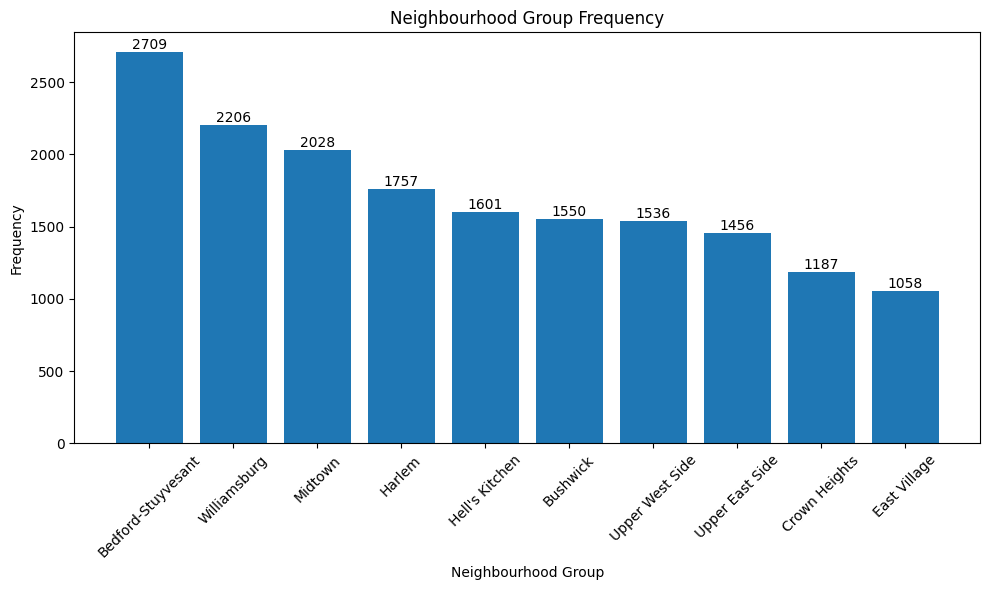

In [178]:
# Drop duplicate rows based on 'neighbourhood_group' and keep the first occurrence
unique_df = geo_data.drop_duplicates(subset='neighbourhood')

top_10_neighbourhoods = unique_df.sort_values(by='neighbourhood_frequency', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(top_10_neighbourhoods['neighbourhood'], top_10_neighbourhoods['neighbourhood_frequency'])

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

# Set labels and title
plt.xlabel('Neighbourhood Group')
plt.ylabel('Frequency')
plt.title('Neighbourhood Group Frequency')

plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.tight_layout()  # Adjust layout to make room for the labels

plt.show()

In [179]:
geo_data.sort_values(by='neighbourhood_group_frequency', ascending=False).head(10)

neighbourhood neighbourhood_group  \
53       Civic Center           Manhattan   
145   Lower East Side           Manhattan   
87       East Village           Manhattan   
131            Inwood           Manhattan   
80        East Harlem           Manhattan   
52            Chelsea           Manhattan   
137          Kips Bay           Manhattan   
139      Little Italy           Manhattan   
142       Murray Hill           Manhattan   
188  Roosevelt Island           Manhattan   

                                              geometry  \
53   MULTIPOLYGON (((-73.99799 40.71272, -73.99777 ...   
145  MULTIPOLYGON (((-73.97489 40.71515, -73.97605 ...   
87   MULTIPOLYGON (((-73.9907 40.73478, -73.98255 4...   
131  MULTIPOLYGON (((-73.9223 40.8556, -73.92253 40...   
80   MULTIPOLYGON (((-73.93383 40.81952, -73.93383 ...   
52   MULTIPOLYGON (((-73.99346 40.75219, -73.98794 ...   
137  MULTIPOLYGON (((-73.97168 40.74304, -73.97189 ...   
139  MULTIPOLYGON (((-73.99439 40.71952, -73.99438 ...   
142  MULTIPOLYGON (((-73.96792 40.74796, -73.96817 ...   
188  MULTIPOLYGON (((-73.9449 40.76948, -73.94472 4...   

     neighbourhood_frequency  neighbourhood_group_frequency  
53                        25                          16715  
145                      613                          16715  
87                      1058                          16715  
131                      183                          16715  
80                       710                          16715  
52                       814                          16715  
137                      381                          16715  
139                      109                          16715  
142                      452                          16715  
188                       43                          16715

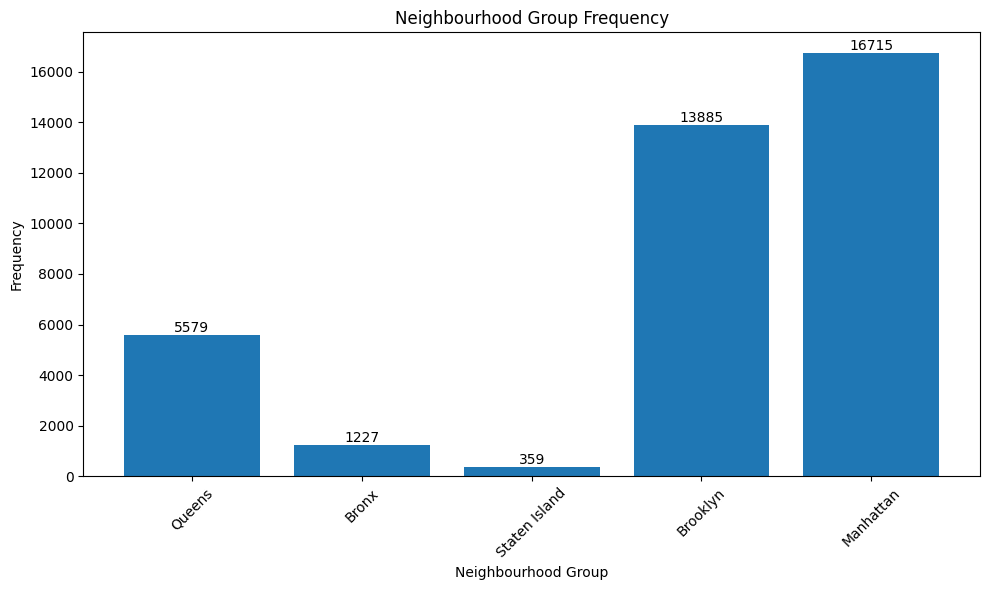

In [180]:
# Drop duplicate rows based on 'neighbourhood_group' and keep the first occurrence
unique_df = geo_data.drop_duplicates(subset='neighbourhood_group')

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(unique_df['neighbourhood_group'], unique_df['neighbourhood_group_frequency'])

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

# Set labels and title
plt.xlabel('Neighbourhood Group')
plt.ylabel('Frequency')
plt.title('Neighbourhood Group Frequency')

plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.tight_layout()  # Adjust layout to make room for the labels

plt.show()

In the above chart we see that Manhattan is the neighbourhood group with most occurrences of listings. This may be due to the fact that Manhattan is larger than Brooklyn and properties are more spread out accross individua neighbourhoods. Brooklyn comes in second right after Manhattan.

### Characteristics of listings on Brooklyn

In [181]:
brooklyn = listings[listings['neighbourhood_group_cleansed'] == 'Brooklyn']
brooklyn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13885 entries, 1 to 37760
Data columns (total 52 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_id                                       13885 non-null  int64  
 1   name                                          13885 non-null  object 
 2   host_location                                 11742 non-null  object 
 3   host_response_time                            7703 non-null   object 
 4   host_response_rate                            7703 non-null   float64
 5   host_acceptance_rate                          8589 non-null   float64
 6   host_is_superhost                             13690 non-null  object 
 7   host_name                                     13881 non-null  object 
 8   host_neighbourhood                            12974 non-null  object 
 9   host_listings_count                           13881 non-null  floa

In [182]:
brooklyn.describe()

host_id  host_response_rate  host_acceptance_rate  \
count  1.388500e+04         7703.000000           8589.000000   
mean   1.318425e+08            0.906682              0.761678   
std    1.697666e+08            0.238880              0.308358   
min    1.678000e+03            0.000000              0.000000   
25%    7.195403e+06            0.980000              0.640000   
50%    4.061117e+07            1.000000              0.910000   
75%    2.152574e+08            1.000000              1.000000   
max    5.869174e+08            1.000000              1.000000   

       host_listings_count  host_total_listings_count      latitude  \
count         13881.000000               13881.000000  13885.000000   
mean             56.750738                  84.642029     40.680906   
std             325.825614                 417.838551      0.028713   
min               1.000000                   1.000000     40.573938   
25%               1.000000                   1.000000     40.667738   
50%               1.000000                   2.000000     40.685120   
75%               3.000000                   6.000000     40.699120   
max            4641.000000                4935.000000     40.738760   

          longitude  accommodates    bathrooms      bedrooms         beds  \
count  13885.000000  13885.000000  8036.000000  11560.000000  8013.000000   
mean     -73.948897      2.701404     1.256284      1.515917     1.679770   
std        0.027958      1.909845     0.583952      1.017499     1.272638   
min      -74.039690      1.000000     0.000000      0.000000     0.000000   
25%      -73.962690      2.000000     1.000000      1.000000     1.000000   
50%      -73.949460      2.000000     1.000000      1.000000     1.000000   
75%      -73.931590      4.000000     1.500000      2.000000     2.000000   
max      -73.857309     16.000000    15.500000     16.000000    42.000000   

       minimum_nights  maximum_nights  availability_30  availability_60  \
count    13885.000000    1.388500e+04     13885.000000     13885.000000   
mean        29.797767    1.989019e+03         8.790565        20.828088   
std         22.279878    1.697254e+05        12.129526        24.297124   
min          1.000000    3.000000e+00         0.000000         0.000000   
25%         30.000000    9.000000e+01         0.000000         0.000000   
50%         30.000000    3.650000e+02         0.000000         5.000000   
75%         30.000000    1.125000e+03        22.000000        47.000000   
max        500.000000    2.000000e+07        30.000000        60.000000   

       availability_90  availability_365  number_of_reviews  \
count     13885.000000      13885.000000       13885.000000   
mean         33.827368        139.662586          29.114152   
std          36.573182        140.918675          60.353988   
min           0.000000          0.000000           0.000000   
25%           0.000000          0.000000           0.000000   
50%          19.000000         90.000000           5.000000   
75%          72.000000        270.000000          28.000000   
max          90.000000        365.000000         673.000000   

       number_of_reviews_ltm  number_of_reviews_l30d  review_scores_rating  \
count           13885.000000            13885.000000          10220.000000   
mean                4.049550                0.292042              4.769043   
std                10.105565                1.090304              0.378102   
min                 0.000000                0.000000              0.000000   
25%                 0.000000                0.000000              4.690000   
50%                 0.000000                0.000000              4.880000   
75%                 3.000000                0.000000              5.000000   
max               343.000000               20.000000              5.000000   

       review_scores_accuracy  review_scores_cleanliness  \
count            10211.000000               10216.000000   
mean                 4.80

In [183]:
brooklyn.head(10)

host_id                                               name host_location  \
1      7378    Spacious Family Friendly Duplex w/ Patio + Yard  New York, NY   
2     15991                   Only 2 stops to Manhattan studio  New York, NY   
5     17297  Amazing location! Wburg. Large, bright & tranquil  New York, NY   
6     17571      Perfect for Your Parents, With Garden & Patio  New York, NY   
7     21207                 Sunny Williamsburg Loft with Sauna  New York, NY   
8     25183   Maison des Sirenes1,bohemian, luminous apartment  New York, NY   
10    35935                           Wonderful B&B Style room  New York, NY   
11    45445                          Country space in the city  New York, NY   
14    50148                 Charming Brownstone 3 - Near PRATT  Berkeley, CA   
15    54275   Writer’s Room for 2 in Brownstone- $1545 monthly  New York, NY   

    host_response_time  host_response_rate  host_acceptance_rate  \
1       within an hour                1.00                  1.00   
2       within an hour                1.00                  1.00   
5   a few days or more                0.00                  0.00   
6       within an hour                1.00                  1.00   
7       within an hour                1.00                  1.00   
8   within a few hours                1.00                  1.00   
10      within an hour                0.90                  0.80   
11                 NaN                 NaN                   NaN   
14        within a day                0.88                  0.98   
15  within a few hours                1.00                  0.96   

   host_is_superhost       host_name  host_neighbourhood  host_listings_count  \
1                  f         Rebecca   Greenwood Heights                  1.0   
2                  t   Allen & Irina        Williamsburg                  1.0   
5                  f          Joelle        Williamsburg                  2.0   
6                  t            Jane         Fort Greene                  2.0   
7                  t           Chaya        Williamsburg                  4.0   
8                  t        Nathalie  Bedford-Stuyvesant                  2.0   
10                 t          Angela  Bedford-Stuyvesant                  6.0   
11                 f         Harriet            Flatbush                  1.0   
14                 f        Adreinne  Bedford-Stuyvesant                  7.0   
15                 f  JT And Tiziana  Stuyvesant Heights                  5.0   

    host_total_listings_count                host_verifications  \
1                         5.0                ['email', 'phone']   
2                         1.0                ['email', 'phone']   
5                         2.0  ['email', 'phone', 'work_email']   
6                         2.0                ['email', 'phone']   
7                         4.0                ['email', 'phone']   
8                         3.0                ['email', 'phone']   
10                        6.0                ['email', 'phone']   
11                        3.0                         ['phone']   
14                        8.0                ['email', 'phone']   
15                        5.0  ['email', 'phone', 'work_email']   

   host_has_profile_pic host_identity_verified neighbourhood_cleansed  \
1                     t                      t            Sunset Park   
2                     t                      t           Williamsburg   
5                     t                      t           Williamsburg   
6                     t                      t            Fort Greene   
7                     t                      t           Williamsburg   
8                     t                      t     Bedford-Stuyvesant   
10                    t                      t     Bedford-Stuyvesant   
11                    t                      f               Flatbush   
14                    t                      t     Bedford-Stuyvesant   
15            

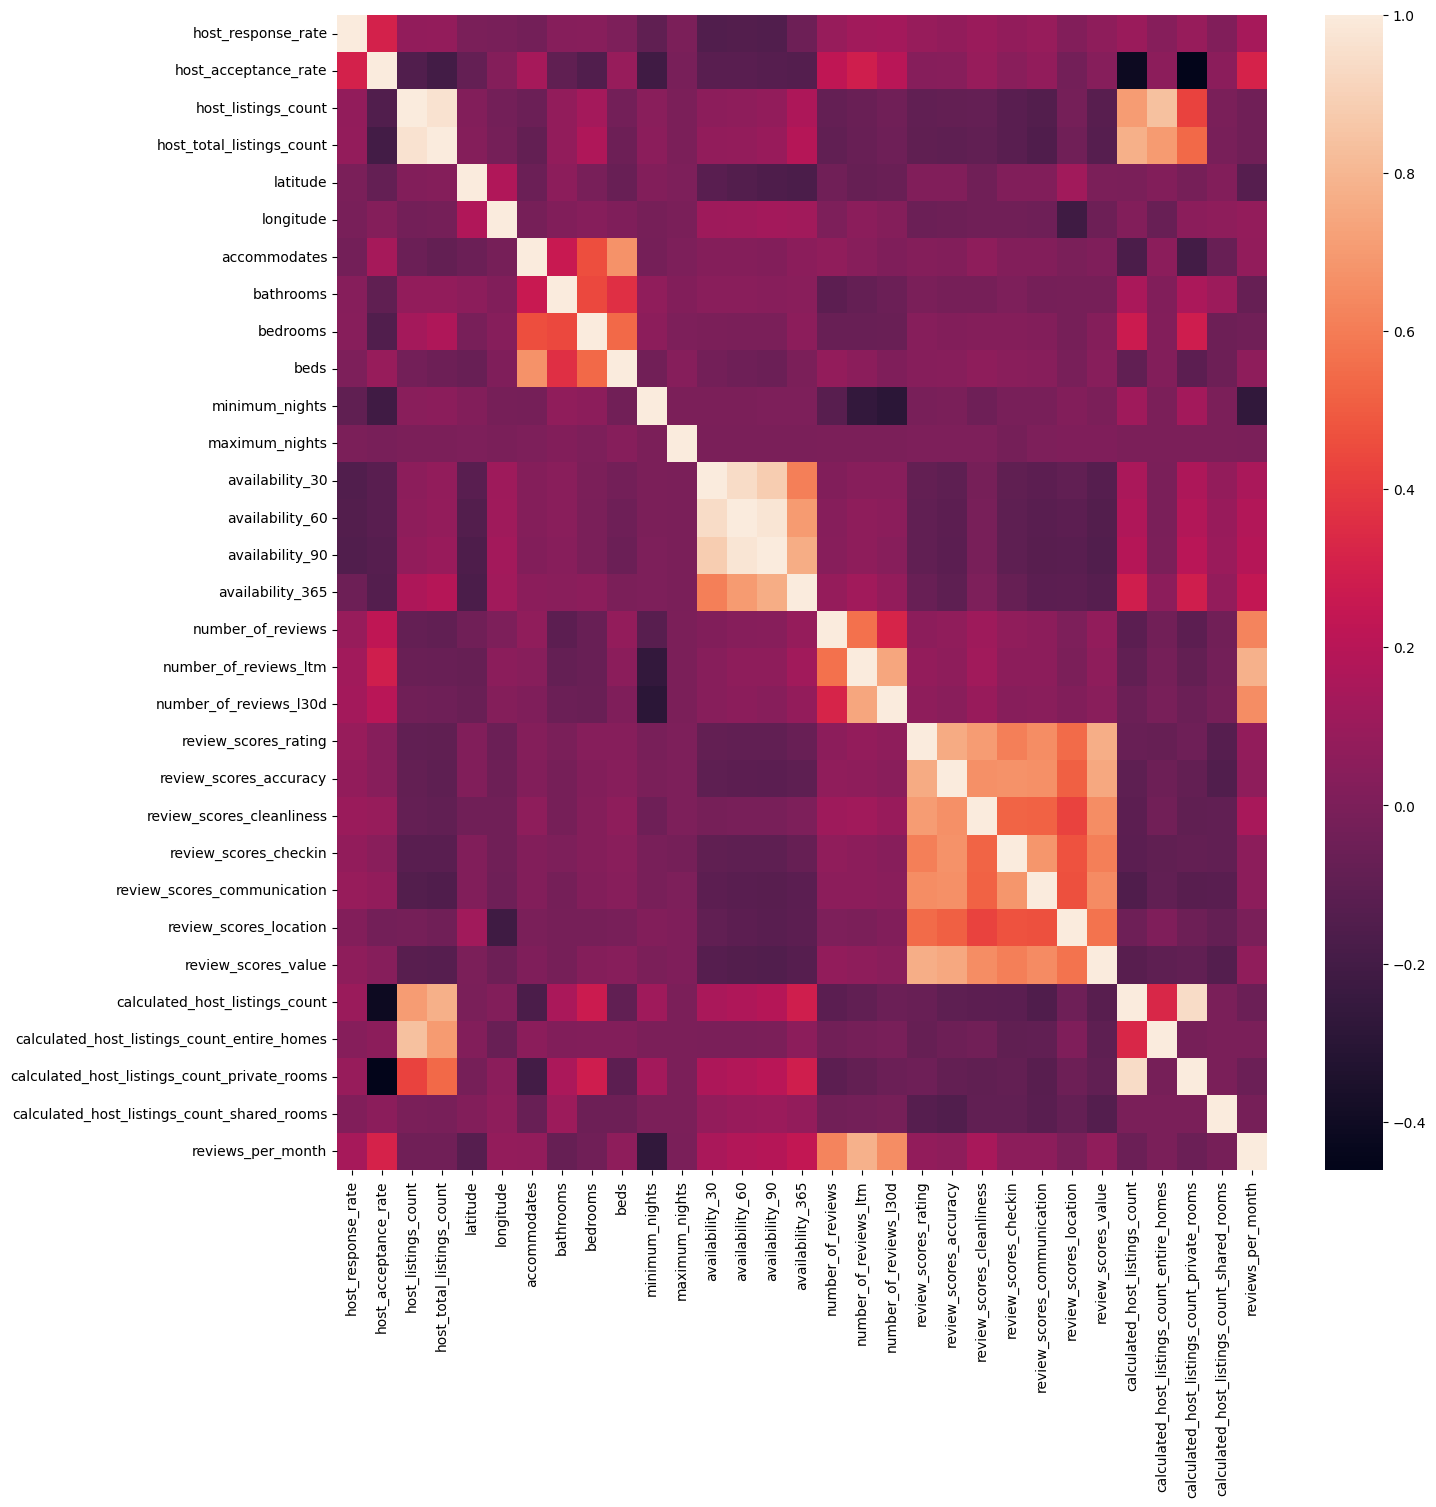

In [184]:
plt.figure(figsize=(15, 15))
corr = brooklyn.drop(['host_id'], axis=1).select_dtypes('number').corr()
sns.heatmap(corr)
plt.show()

Let's explore the inverse correlation between host_acceptance_rate and calculated_host_listings_count

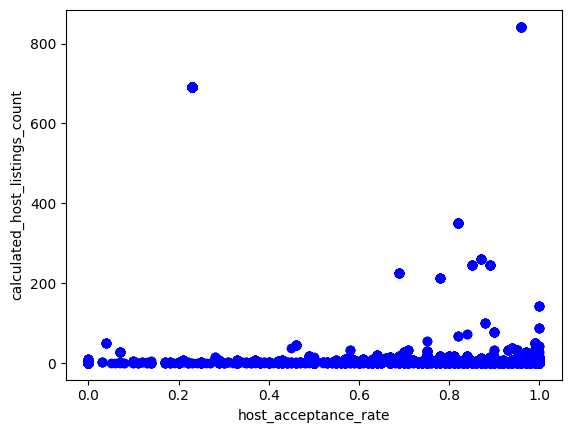

In [185]:
plt.scatter(brooklyn['host_acceptance_rate'], brooklyn['calculated_host_listings_count'], color='blue', marker='o')

# Add titles and labels
plt.xlabel('host_acceptance_rate')
plt.ylabel('calculated_host_listings_count')

# Show the plot
plt.show()

Only through visualization we see no direct inverse correlation between these two variables. The inverse correlation might be due to the effect of outliers, affecting the calculation of pearson's correlation by adding too much variance, creating correlation where there really isn't. Statistical investigation is required but I'll skip since this isn't the focus for this analysis.

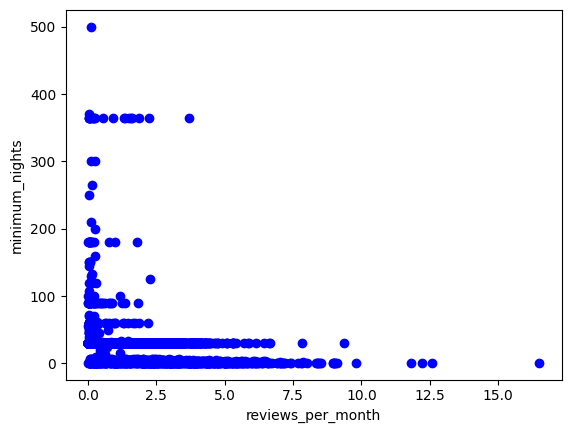

In [186]:
plt.scatter(brooklyn['reviews_per_month'], brooklyn['minimum_nights'], color='blue', marker='o')

# Add titles and labels
plt.xlabel('reviews_per_month')
plt.ylabel('minimum_nights')

# Show the plot
plt.show()

Here we identify a logical inverse correlation. The less nights one has to stay in a property, more people can come through thus more reviews can be made.

<Axes: >

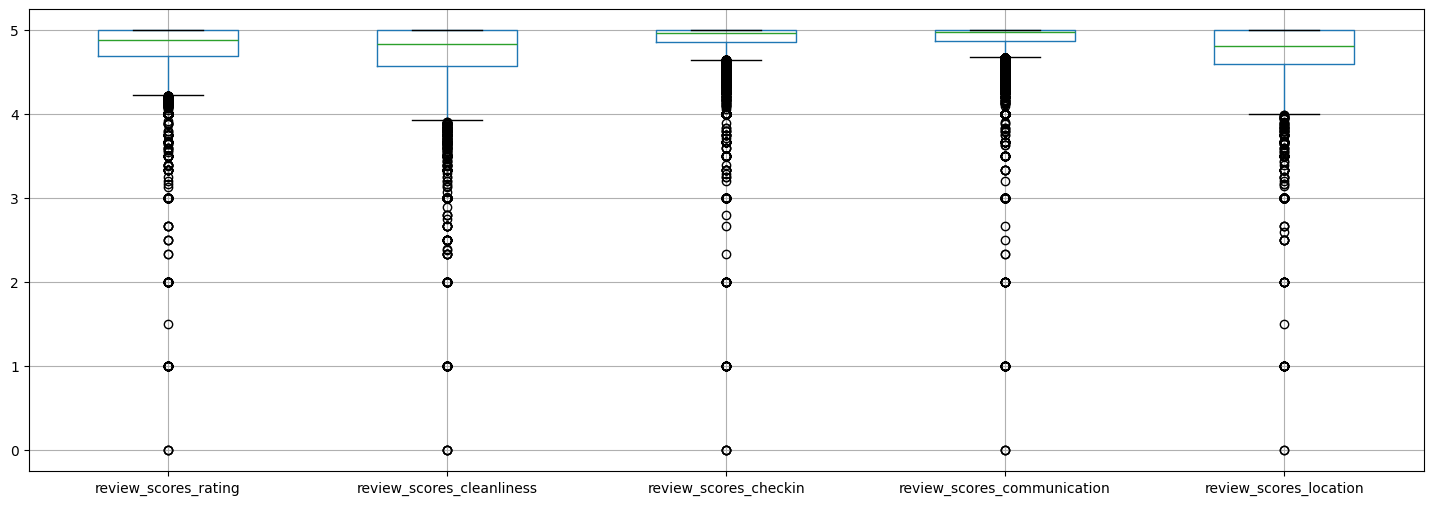

In [187]:
only_reviews = brooklyn[['review_scores_rating', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location']]
only_reviews.boxplot(figsize=(18, 6))

Reviews for Brooklyn listings tend to be majorly positive, with lower fence being a bit below for for cleanliness only.

<Axes: >

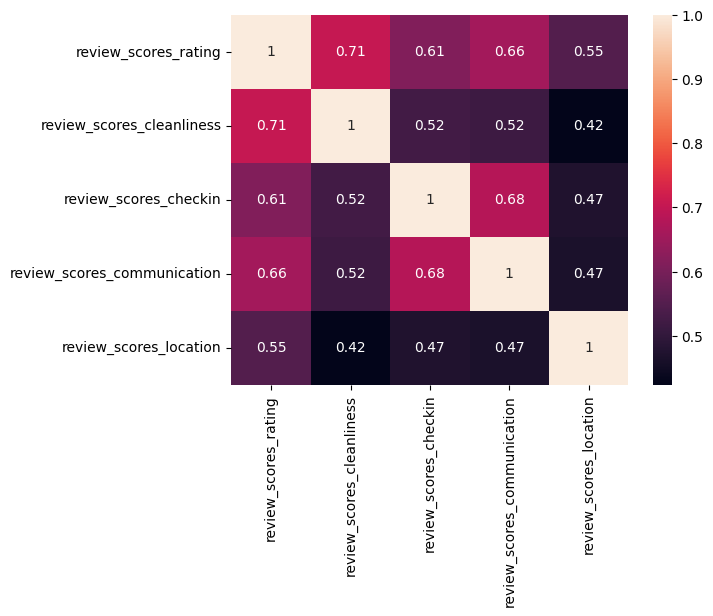

In [188]:
# Create pairplot
sns.heatmap(only_reviews.corr(), annot=True)

Visualizing review correlations we see that there isn't a very strong (> 0.8) correlation between any of the reviews. Meaning that mostly, just because one aspect got maximum rating doesn't mean all aspects will always follow the trend

In [189]:

def find_number(element):
    pattern = r'\d+'

    match = re.search(pattern, str(element))
    if match:
        return int(match.group())
    else:
        return None
    


brooklyn['bathrooms'] = brooklyn['bathrooms_text'].apply(find_number)
brooklyn.drop('bathrooms_text', axis=1, inplace=True)

print(f"mean number of bathrooms, bedrooms and accomodates in brooklyn: {str(brooklyn['bathrooms'].mean())}, {str(brooklyn['bedrooms'].mean())}, {str(brooklyn['accommodates'].mean())}")

mean number of bathrooms, bedrooms and accomodates in brooklyn: 1.1841496893512498, 1.515916955017301, 2.7014043932301046


/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_5570/962080084.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_5570/962080084.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [190]:
brooklyn[['bathrooms', 'bedrooms', 'accommodates']].describe()

bathrooms      bedrooms  accommodates
count  13842.000000  11560.000000  13885.000000
mean       1.184150      1.515917      2.701404
std        0.495015      1.017499      1.909845
min        0.000000      0.000000      1.000000
25%        1.000000      1.000000      2.000000
50%        1.000000      1.000000      2.000000
75%        1.000000      2.000000      4.000000
max       15.000000     16.000000     16.000000

<Axes: >

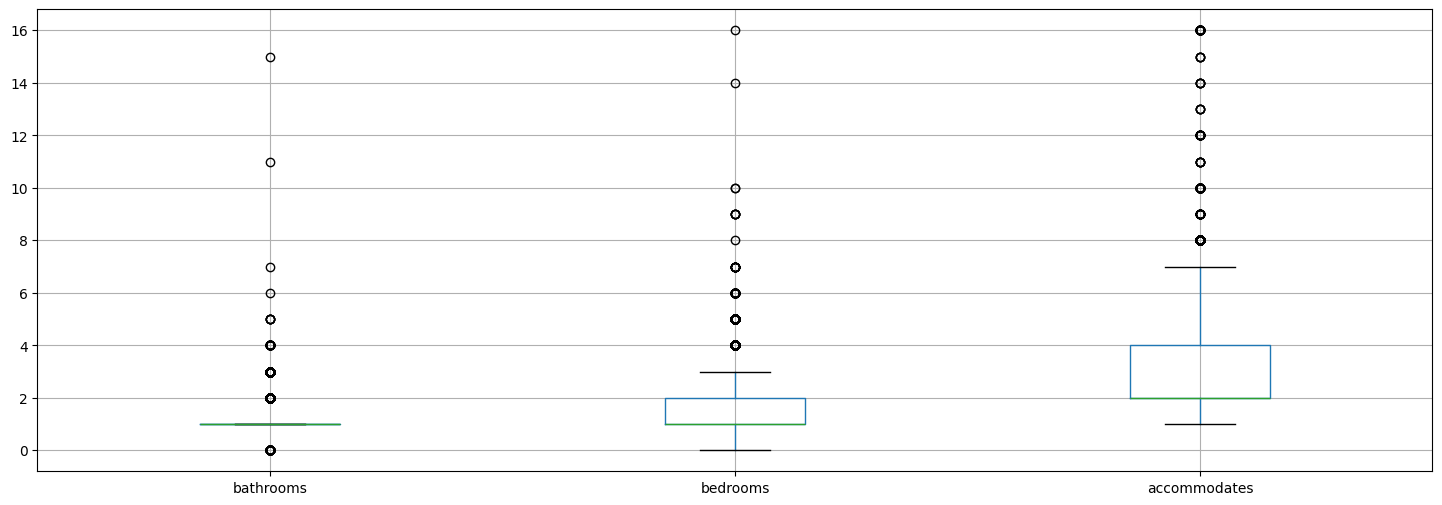

In [192]:
only_sizes = brooklyn[['bathrooms', 'bedrooms', 'accommodates']]
only_sizes.boxplot(figsize=(18, 6))

Most properties are on the lower end of the bedroom and bathroom count, with a few outliers skewing to the right, and the 75th percentile of accommodates going up to 4 people.

In [191]:
px.histogram(brooklyn, x='room_type', title="Distribution of Room Types in Brooklyn", text_auto=True)


Most properties are Private Rooms, followed by Entire Home/apt.

### Comparing Brooklyn and Manhattan's characteristics

In [193]:
manhattan = listings[listings['neighbourhood_group_cleansed'] == 'Manhattan']
manhattan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16715 entries, 0 to 37762
Data columns (total 52 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_id                                       16715 non-null  int64  
 1   name                                          16714 non-null  object 
 2   host_location                                 12794 non-null  object 
 3   host_response_time                            10604 non-null  object 
 4   host_response_rate                            10604 non-null  float64
 5   host_acceptance_rate                          11159 non-null  float64
 6   host_is_superhost                             16605 non-null  object 
 7   host_name                                     16714 non-null  object 
 8   host_neighbourhood                            10551 non-null  object 
 9   host_listings_count                           16714 non-null  floa

In [ ]:
manhattan['bathrooms'] = manhattan['bathrooms_text'].apply(find_number)
manhattan.drop('bathrooms_text', axis=1, inplace=True)

In [194]:
px.histogram(manhattan, x='room_type', title="Distribution of Room Types in Manhattan", text_auto=True)

From the get-go we can tell that the ratio of Entire home/apt to Private rooms is way more discrepant in Manhattan than it is in Brooklyn. And Manhattan also has more Hotel Rooms available. This makes sense considering Manhattan is more "central" than Brooklyn, even though brooklyn has more area.

<Axes: >

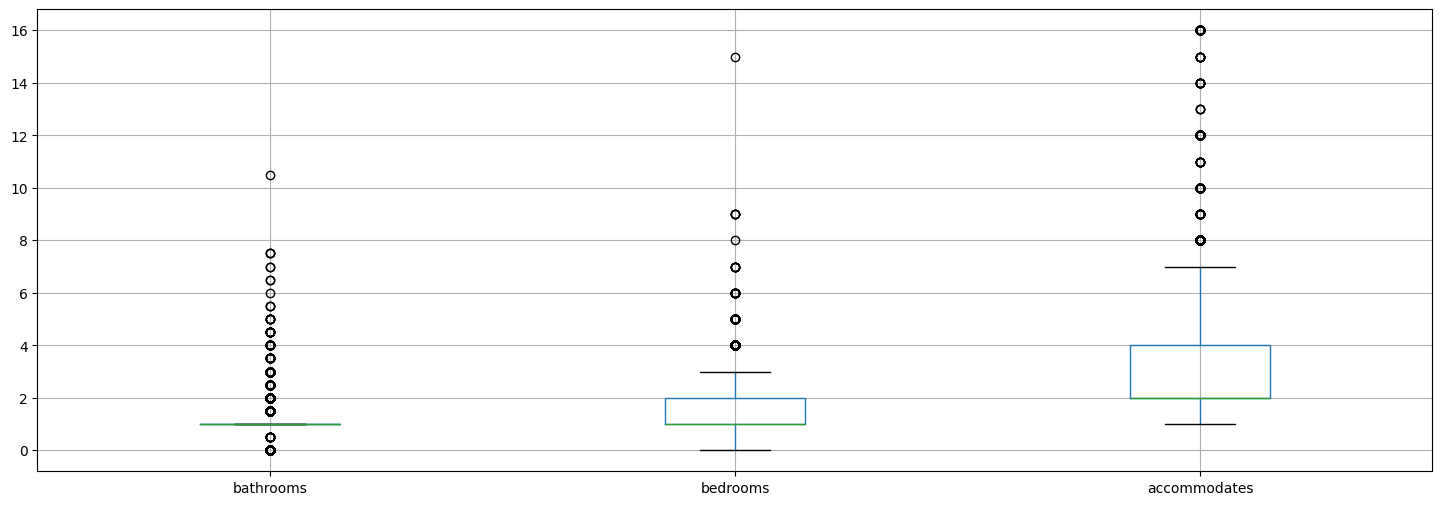

In [195]:
manhattan_only_sizes = manhattan[['bathrooms', 'bedrooms', 'accommodates']]
manhattan_only_sizes.boxplot(figsize=(18, 6))

In [197]:
only_sizes.describe()

bathrooms      bedrooms  accommodates
count  13842.000000  11560.000000  13885.000000
mean       1.184150      1.515917      2.701404
std        0.495015      1.017499      1.909845
min        0.000000      0.000000      1.000000
25%        1.000000      1.000000      2.000000
50%        1.000000      1.000000      2.000000
75%        1.000000      2.000000      4.000000
max       15.000000     16.000000     16.000000

In [196]:
manhattan_only_sizes.describe()

bathrooms      bedrooms  accommodates
count  10081.000000  14349.000000  16715.000000
mean       1.150679      1.282041      2.863536
std        0.560445      0.885310      1.913996
min        0.000000      0.000000      1.000000
25%        1.000000      1.000000      2.000000
50%        1.000000      1.000000      2.000000
75%        1.000000      2.000000      4.000000
max       10.500000     15.000000     16.000000

The distribution of bathroom, bedroom and accommodate counts is very similar between these two neighbourhood groups.

<Axes: >

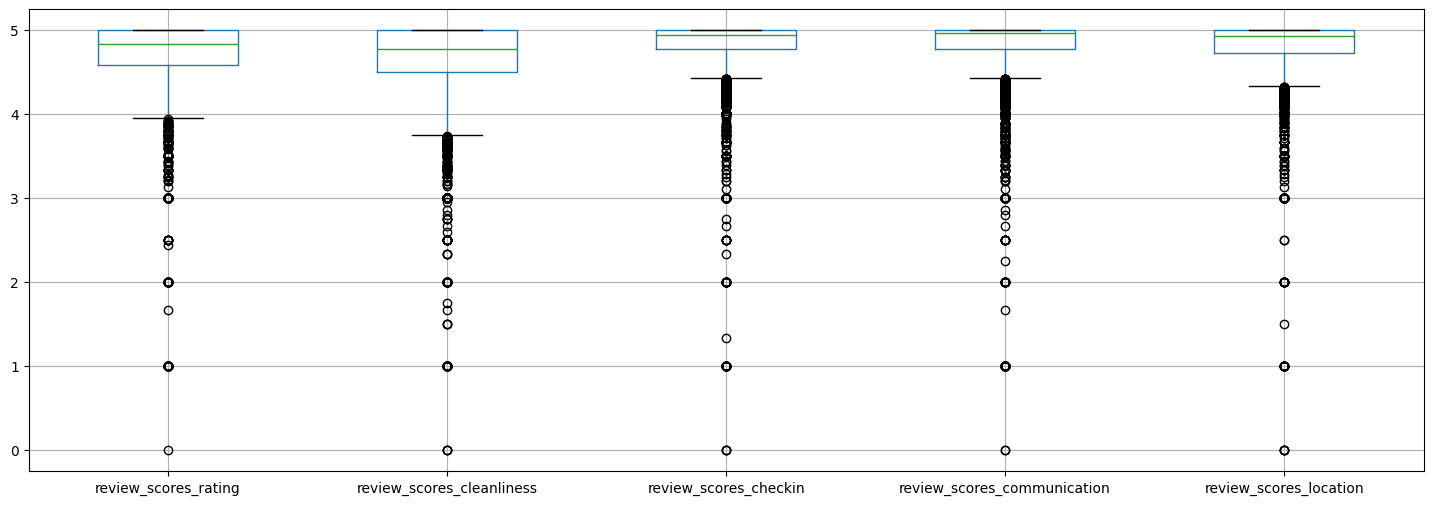

In [198]:
manhattan_only_reviews = manhattan[['review_scores_rating', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location']]
manhattan_only_reviews.boxplot(figsize=(18, 6))

In [224]:
ratings_geo = geo_data.copy()
ratings_geo['mean_rating_per_neighbourhood'] = ratings_geo['neighbourhood'].apply(lambda x: (listings[listings['neighbourhood_cleansed'] == x]['review_scores_rating'].mean()))
ratings_geo = ratings_geo[(ratings_geo['neighbourhood_group'] == 'Manhattan') | (ratings_geo['neighbourhood_group'] == 'Brooklyn')]
ratings_geo.sort_values('mean_rating_per_neighbourhood', ascending=False).head(5)

neighbourhood neighbourhood_group  \
162        Navy Yard            Brooklyn   
186         Sea Gate            Brooklyn   
147      Marble Hill           Manhattan   
12   Gerritsen Beach            Brooklyn   
62       Columbia St            Brooklyn   

                                              geometry  \
162  MULTIPOLYGON (((-73.96748 40.70395, -73.96721 ...   
186  MULTIPOLYGON (((-74.00388 40.58164, -74.00395 ...   
147  MULTIPOLYGON (((-73.90893 40.87216, -73.90893 ...   
12   MULTIPOLYGON (((-73.93503 40.60173, -73.93354 ...   
62   MULTIPOLYGON (((-74.00174 40.69241, -73.99925 ...   

     neighbourhood_frequency  neighbourhood_group_frequency  \
162                        6                          13885   
186                       19                          13885   
147                        8                          16715   
12                         6                          13885   
62                        20                          13885   

     mean_rating_per_neighbourhood  
162                       5.000000  
186                       4.916667  
147                       4.915714  
12                        4.896000  
62                        4.895000

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_5570/1784291362.py:15: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




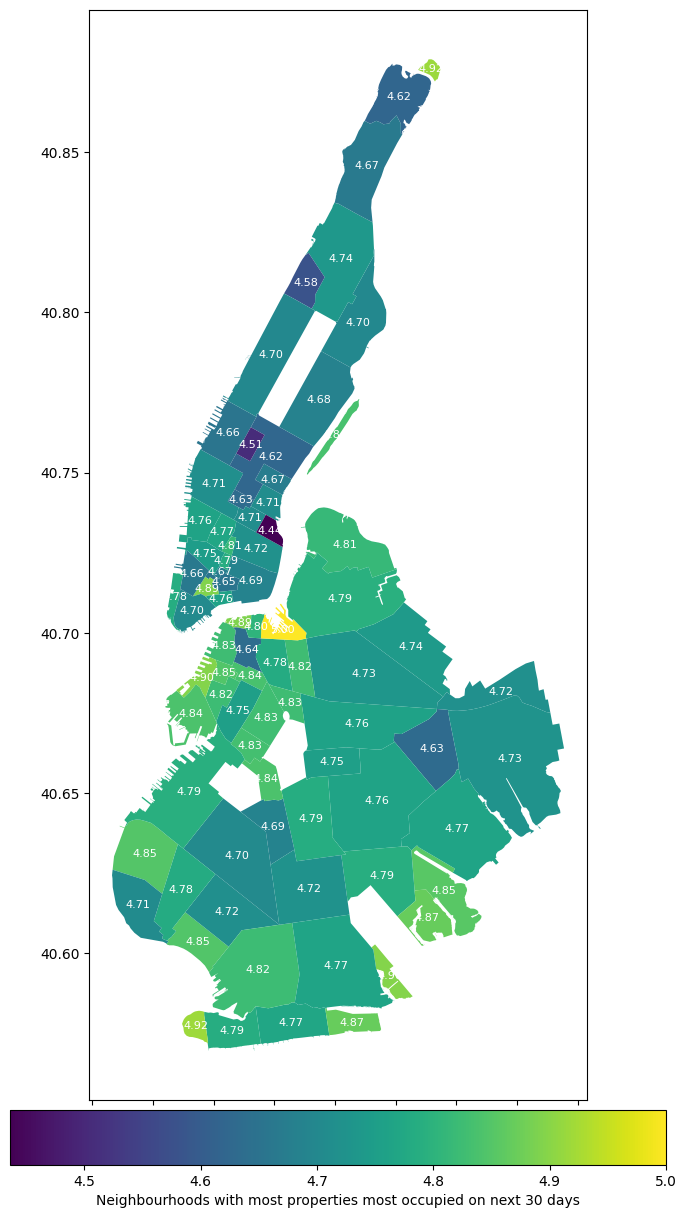

In [226]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="5%", pad=0.1)

ratings_geo.plot(
    ax=ax, 
    cax=cax, 
    legend=True, 
    column='mean_rating_per_neighbourhood',
    legend_kwds={"label": "Neighbourhoods with most properties most occupied on next 30 days", "orientation": "horizontal"}
)

for x, y, label in zip(ratings_geo.geometry.centroid.x, ratings_geo.geometry.centroid.y, ratings_geo['mean_rating_per_neighbourhood']):
    ax.text(x, y, '{:.2f}'.format(label), fontsize=8, ha='center', va='center', color='white')  # Position the text

plt.show()

In [199]:
only_reviews.describe()

review_scores_rating  review_scores_cleanliness  review_scores_checkin  \
count          10220.000000               10216.000000           10209.000000   
mean               4.769043                   4.682664               4.864905   
std                0.378102                   0.469441               0.322596   
min                0.000000                   0.000000               0.000000   
25%                4.690000                   4.570000               4.860000   
50%                4.880000                   4.830000               4.970000   
75%                5.000000                   5.000000               5.000000   
max                5.000000                   5.000000               5.000000   

       review_scores_communication  review_scores_location  
count                 10214.000000            10209.000000  
mean                      4.866106                4.719707  
std                       0.331979                0.376737  
min                       0.000000                0.000000  
25%                       4.870000                4.600000  
50%                       4.980000                4.810000  
75%                       5.000000                5.000000  
max                       5.000000                5.000000

In [200]:
manhattan_only_reviews.describe()

review_scores_rating  review_scores_cleanliness  review_scores_checkin  \
count          10556.000000               10554.000000           10550.000000   
mean               4.689906                   4.620211               4.805680   
std                0.481811                   0.530831               0.410049   
min                0.000000                   0.000000               0.000000   
25%                4.580000                   4.500000               4.770000   
50%                4.830000                   4.780000               4.940000   
75%                5.000000                   5.000000               5.000000   
max                5.000000                   5.000000               5.000000   

       review_scores_communication  review_scores_location  
count                 10553.000000            10548.000000  
mean                      4.795729                4.794717  
std                       0.451147                0.380884  
min                       0.000000                0.000000  
25%                       4.770000                4.730000  
50%                       4.960000                4.930000  
75%                       5.000000                5.000000  
max                       5.000000                5.000000

When it comes to reviews, Manhattan's highest scores for location are grouped together much above 4. This could be due to several reasons, but one of them could be the fact that Brooklyn is not as close to the main places, offices, sights, anything that people might be looking for in New York City, which is something travelers should keep an eye on before booking a place. Brooklyn's properties' ratings for cleanliness take the lead on Manhattan by a few decimal points. The other reviews are pretty similar with Brooklyn taking the overall lead.

### What type of property people look for the most in Manhattan, the neighbourhood group with most properties?

Let's analyze characteristics for properties with no availability in the following 30 days from the last day collected

In [210]:
listings_least_available = manhattan[manhattan['availability_30'] == 0].dropna(subset=['availability_30'])
listings_least_available.shape

(9172, 52)

<Axes: >

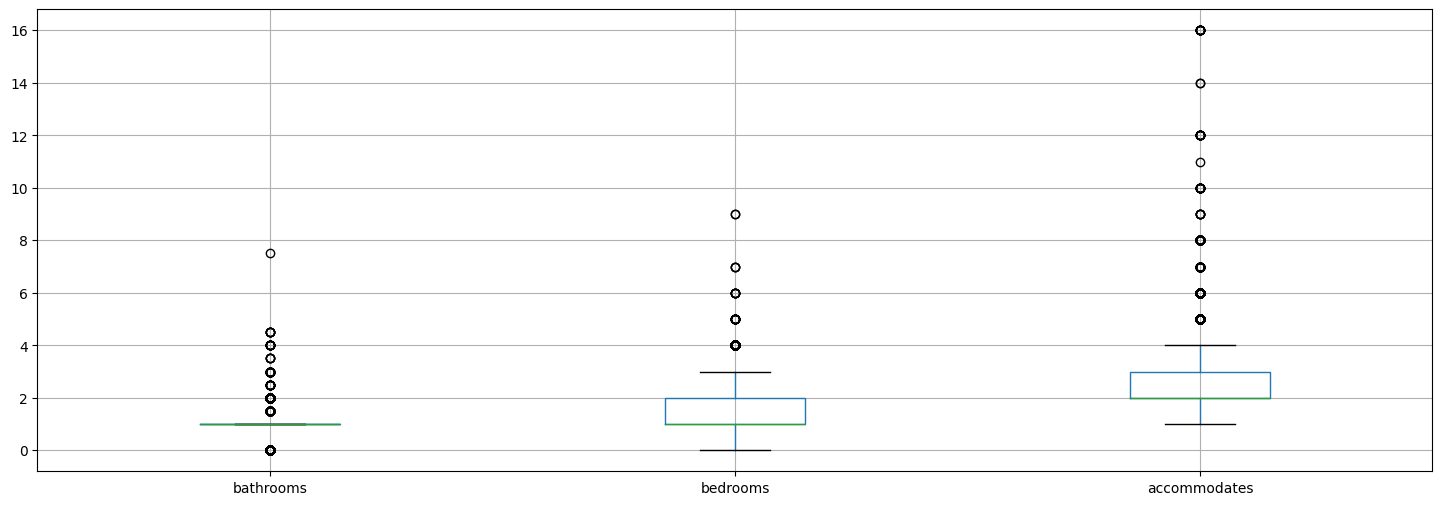

In [211]:
least_available_only_sizes = listings_least_available[['bathrooms', 'bedrooms', 'accommodates']]
least_available_only_sizes.boxplot(figsize=(18, 6))

Here we can see that from the properties with no availability on the following 30 days, the statistics for bathroom and bedroom count stay the same but for accomodates decreases. This could indicate that for the following 30 days people looked for the most for places for fewer people. Let's examine the mean night stay at these places

In [214]:
print(listings_least_available['minimum_nights'].describe())
print("\n")
print(manhattan['minimum_nights'].describe())

count    9172.000000
mean       31.226341
std        29.281328
min         1.000000
25%        30.000000
50%        30.000000
75%        30.000000
max      1250.000000
Name: minimum_nights, dtype: float64


count    16715.000000
mean        28.239725
std         31.540108
min          1.000000
25%         30.000000
50%         30.000000
75%         30.000000
max       1250.000000
Name: minimum_nights, dtype: float64


The median minimum nights stayed the same, but the mean got closer, and surpassed the median. This could mean that most properties not available for the following 30 days, on median, are those with higher minumum stay. Higher minimum stays often provide interesting weekly or monthly discounts (https://airbnb.com/help/article/2729) so that may be a good reason. Also the next 30 days for the date this was collected includes almost all of July, which is known for a high vacation season.

Now let's see where most of these properties are located

In [221]:
geo_least_available = geo_data.copy()
geo_least_available['properties_per_neighbourhood'] = geo_least_available['neighbourhood'].apply(lambda x: (listings_least_available['neighbourhood_cleansed'] == x).sum())
geo_least_available = geo_least_available[geo_least_available['neighbourhood_group'] == 'Manhattan']
geo_least_available.sort_values('properties_per_neighbourhood', ascending=False).head(5)

neighbourhood neighbourhood_group  \
219  Upper West Side           Manhattan   
119           Harlem           Manhattan   
218  Upper East Side           Manhattan   
121   Hell's Kitchen           Manhattan   
87      East Village           Manhattan   

                                              geometry  \
219  MULTIPOLYGON (((-73.95836 40.80037, -73.98144 ...   
119  MULTIPOLYGON (((-73.93457 40.82815, -73.93442 ...   
218  MULTIPOLYGON (((-73.94359 40.78275, -73.94365 ...   
121  MULTIPOLYGON (((-73.99072 40.75595, -73.99073 ...   
87   MULTIPOLYGON (((-73.9907 40.73478, -73.98255 4...   

     neighbourhood_frequency  neighbourhood_group_frequency  \
219                     1536                          16715   
119                     1757                          16715   
218                     1456                          16715   
121                     1601                          16715   
87                      1058                          16715   

     properties_per_neighbourhood  
219                           912  
119                           894  
218                           871  
121                           785  
87                            780

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_5570/1448432039.py:15: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




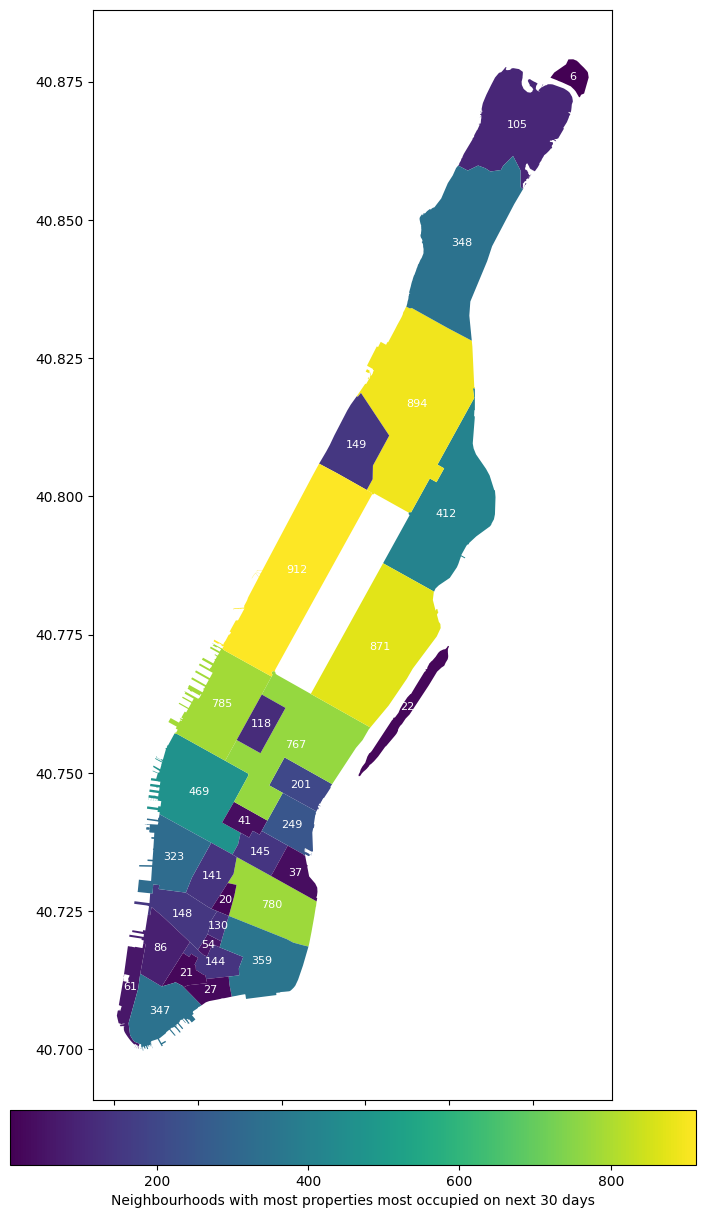

In [219]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="5%", pad=0.1)

geo_least_available.plot(
    ax=ax, 
    cax=cax, 
    legend=True, 
    column='properties_per_neighbourhood',
    legend_kwds={"label": "Neighbourhoods with most properties most occupied on next 30 days", "orientation": "horizontal"}
)

for x, y, label in zip(geo_least_available.geometry.centroid.x, geo_least_available.geometry.centroid.y, geo_least_available['properties_per_neighbourhood']):
    if label > 0:
        ax.text(x, y, str(label), fontsize=8, ha='center', va='center', color='white')  # Position the text

plt.show()

Above we see that most properties that are fully booked are located on Upper West Side. It's important to keep in mind also that the area is pretty large which justify having all these properties, doesn't necessarily mean people are actively looking for Upper West Side the most.

# Discussion

This analysis had the goal of finding out what kinds of properties are on New York City's Airbnb listing. We found out most properties are in Manhattan, but the best reviwed ones are in Brooklyn. The single neighbourhood with most properties is Bedford-Stuyvesant in Brooklyn. Many locations in Manhattan are fully booked for the following 30 days, and this could be due to vacation times. One important finding for future travelers is that Manhattan has highest mean and median reviews for location, this could be due to the fact that in Manhattan are located many of the most famout sightseeing spots, offices, and other important locations. One more finding was that Brooklyn has more of a balanced ratio of Entire home to Private room properties, while Manhattan has nearly double the ammount of Entire homes than Private rooms, pointing the offer difference between these two regions. The final goal of this analysis was practicing the use of geographical heatmap visualizations using geopandas with geojson data.

# Suggestions for the future

The dataset contains a full reviews.csv file, which can be useful for a sentiment analysis on different regions of New York City and better understanding the reasons behind the ratings. This should be kept as an idea for later

# References

- https://insideairbnb.com/get-the-data/
- https://medium.com/@tmango/plotting-geojson-files-with-matplotlib-5ed87df570ab
- https://www.theblueground.com/furnished-apartments-new-york-usa

